<a href="https://colab.research.google.com/github/wmFrank/food_word_clustering/blob/main/food_word_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nutrition GRA -- food word clustering

***Note: This code runs on google colab(CPU mode), make sure to upload the file 'MenuItem.csv' to colab before running.***

## install packages


In [ ]:
# install package for sentence embedding
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## import libs

In [ ]:
# import all the libs that used
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

## read data

In [ ]:
# use pandas to read the data
df = pd.read_csv('./MenuItem.csv')

# test
print(df.shape)
print(df.head())

(4524, 2)
   Restaurant Name                         Original food Item
0      Coffee Time                  Garden Vegetable Sandwich
1            HoSan                      Roasted Seaweed Snack
2  Weight Watchers                                    Muffins
3      Natural Sea                 Albacore Tuna, Solid White
4    World of Beer  Caesar Salad with Grilled Flat Iron Steak


## genetate food word embedding

In [ ]:
# import pretrained sentence embedding model
embedding = SentenceTransformer('all-MiniLM-L6-v2')

# test
st = df['Original food Item'][0]
st_embedding = embedding.encode(st)
print(st)
print(st_embedding.shape)

Garden Vegetable Sandwich
(384,)


In [ ]:
# apply embedding model to all the food words
df_cp = df.copy()
df_cp['Food word embedding'] = df_cp['Original food Item'].apply(embedding.encode)

# test
print(df_cp['Food word embedding'][10].shape)
print(df_cp.head())

(384,)
   Restaurant Name                         Original food Item  \
0      Coffee Time                  Garden Vegetable Sandwich   
1            HoSan                      Roasted Seaweed Snack   
2  Weight Watchers                                    Muffins   
3      Natural Sea                 Albacore Tuna, Solid White   
4    World of Beer  Caesar Salad with Grilled Flat Iron Steak   

                                 Food word embedding  
0  [-0.07399012, 0.032178428, -0.009764364, -0.05...  
1  [-0.026096214, 0.045596484, -0.059656065, 0.06...  
2  [-0.0087166075, -0.046080444, 0.058492344, 0.0...  
3  [-0.019355945, -0.019507144, -0.02942954, 0.05...  
4  [-0.058515932, -0.043719836, -0.09040273, 0.06...  


In [ ]:
# generate embedding for each restaurant using the mean of corresponding food word embeddings
df_restaurant = df_cp.groupby('Restaurant Name', sort=False)['Food word embedding'].mean().reset_index()

# test
print(df_restaurant.shape)
print(df_restaurant.head())
print(df_restaurant['Food word embedding'][4].shape)

(341, 2)
   Restaurant Name                                Food word embedding
0      Coffee Time  [-0.03476875, 0.0037624289, 0.007855713, 0.022...
1            HoSan  [-0.0906317, 0.01902882, -0.029223328, 0.05340...
2  Weight Watchers  [-0.04376568, -0.022377858, 0.019955868, 0.030...
3      Natural Sea  [-0.04530863, -0.004409209, -0.013963228, 0.01...
4    World of Beer  [-0.045633048, 0.009781356, -0.016326033, 0.02...
(384,)


## cluster the restaurants

In [ ]:
# use PCA to reduce the dimensionality of the restaurant embedding
pca = PCA(n_components=2)
df_restaurant['2-d embedding'] = pca.fit_transform(df_restaurant['Food word embedding'].tolist()).tolist()
df_restaurant['2-d embedding'] = df_restaurant['2-d embedding'].apply(np.array)

# test
print(df_restaurant.shape)
print(df_restaurant.head())
print(df_restaurant['2-d embedding'][5].shape)

(341, 3)
   Restaurant Name                                Food word embedding  \
0      Coffee Time  [-0.03476875, 0.0037624289, 0.007855713, 0.022...   
1            HoSan  [-0.0906317, 0.01902882, -0.029223328, 0.05340...   
2  Weight Watchers  [-0.04376568, -0.022377858, 0.019955868, 0.030...   
3      Natural Sea  [-0.04530863, -0.004409209, -0.013963228, 0.01...   
4    World of Beer  [-0.045633048, 0.009781356, -0.016326033, 0.02...   

                                 2-d embedding  
0  [0.11959862804262418, 0.007139922502537983]  
1  [-0.0620573199124133, -0.06893917478228541]  
2   [0.21520623934347258, 0.05325746055560424]  
3  [-0.15901873006890468, 0.05222593865680723]  
4  [-0.08967039614162091, 0.07000269833077988]  
(2,)


In [ ]:
# Use kmeans to cluster the restaurants based on their 2-d embedding
kmeans = KMeans(n_clusters= 9)
X = df_restaurant['2-d embedding'].tolist()
df_restaurant['label'] = kmeans.fit_predict(X)

# test
print(df_restaurant.head())
print(df_restaurant['label'].value_counts())

   Restaurant Name                                Food word embedding  \
0      Coffee Time  [-0.03476875, 0.0037624289, 0.007855713, 0.022...   
1            HoSan  [-0.0906317, 0.01902882, -0.029223328, 0.05340...   
2  Weight Watchers  [-0.04376568, -0.022377858, 0.019955868, 0.030...   
3      Natural Sea  [-0.04530863, -0.004409209, -0.013963228, 0.01...   
4    World of Beer  [-0.045633048, 0.009781356, -0.016326033, 0.02...   

                                 2-d embedding  label  
0  [0.11959862804262418, 0.007139922502537983]      8  
1  [-0.0620573199124133, -0.06893917478228541]      0  
2   [0.21520623934347258, 0.05325746055560424]      2  
3  [-0.15901873006890468, 0.05222593865680723]      1  
4  [-0.08967039614162091, 0.07000269833077988]      1  
1    74
8    70
0    42
7    38
2    32
3    29
5    29
4    18
6     9
Name: label, dtype: int64


In [ ]:
# evaluate the clustering model(with no ground truth)
## Silhouette Coefficient [range(-1, 1), the larger, the better]
labels = kmeans.labels_
ss = metrics.silhouette_score(X, labels, metric='cosine')
print('silhouette score is: ', ss)

## Calinski-Harabasz Index [the larger, the better]
chs = metrics.calinski_harabasz_score(X, labels)
print('calinski harabasz score is: ', chs)

## Davies-Bouldin Index [range(0, +∞), the smaller, the better]
dbs = metrics.davies_bouldin_score(X, labels)
print('davies bouldin score is: ', dbs)

silhouette score is:  -0.08909369171385324
calinski harabasz score is:  251.594606632639
davies bouldin score is:  0.8305931924242772


[0 1 2 3 4 5 6 7 8]


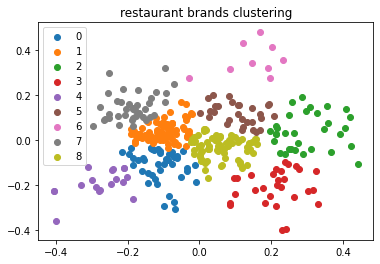

In [ ]:
# visualize the results
u_labels = np.unique(df_restaurant['label'])
print(u_labels)

for i in u_labels:
    data = df_restaurant[df_restaurant['label'] == i]['2-d embedding']
    plt.scatter(data.apply(lambda x: x[0]), data.apply(lambda x: x[1]), label = i)
plt.title('restaurant brands clustering')
plt.legend()
plt.show()

In [ ]:
# sense check
## randomly choose two restaurants in the same label
res = df_restaurant[df_restaurant['label'] == 0]['Restaurant Name'].sample(2).tolist()
print('chosen restaurants: [', res[0], '] AND [', res[1], ']')

## randomly choose one food from these two restaurants
food0 = df[df['Restaurant Name'] == res[0]]['Original food Item'].sample(1).tolist()[0]
food1 = df[df['Restaurant Name'] == res[1]]['Original food Item'].sample(1).tolist()[0]
print('[', res[0], '] has food: ', food0)
print('[', res[1], '] has food: ', food1)

## one sample output will be
# chosen restaurants: [ Sonny's Real Pit Bar-b-q ] AND [ Dell Alpe ]
# [ Sonny's Real Pit Bar-b-q ] has food:  Bar-B-Q Sauce, Authentic Sweet
# [ Dell Alpe ] has food:  Red Peppers, Italian Style Sweet
# It makes sense because these two resturants all have Sweet, and they seem to focus on sauce and seasoning.

## another sample output will be
# chosen restaurants: [ Portillo's ] AND [ Sujata ]
# [ Portillo's ] has food:  Tuna Salad Sandwich
# [ Sujata ] has food:  Roti
# It makes sense becuase Tuna Salad Sandwich is similar to Roti(a kind of bread).

chosen restaurants: [ Portillo's ] AND [ Sujata ]
[ Portillo's ] has food:  Tuna Salad Sandwich
[ Sujata ] has food:  Roti
